# Sprint 3


### Sistemas de Recomendación

#### 1 Introducción
En este trabajo, abordaran el desarrollo de un sistema de recomendación para un conjunto de datos de anime.
El objetivo es crear un sistema que genere recomendaciones personalizadas para todos los usuarios, incluyendo
aquellos que no tienen ningún historial de visualización en el conjunto de entrenamiento.

Los datos necesarios para este proyecto se encuentran en el siguiente enlace: Enlace al conjunto de datos: https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?resource=download

Respecto de la entrega, debe subir las notebooks junto a las presentaciones a un repositorio público en GitHub
y enviar el enlace a max.daniels77@gmail.com.

In [1]:
# Importamos librerías.
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go  # for 3D plot visualization
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from lightfm import LightFM
from scipy.sparse import csr_matrix
import pickle
from sklearn.metrics import average_precision_score
import implicit
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from sklearn.preprocessing import label_binarize

C:\ProgramData\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning:

LightFM was compiled without OpenMP support. Only a single thread will be used.



In [2]:
# Importamos los conjuntos de datos.
anime=pd.read_csv('anime.csv')
anime_with_synopsis=pd.read_csv('anime_with_synopsis.csv')
rating_complete=pd.read_csv('rating_complete.csv')
animelist=pd.read_csv('animelist.csv')
watching_status=pd.read_csv('watching_status.csv')
anime_metadata = anime
interactions = animelist

### Conociendo los Datasets

#### anime.csv
	MAL_ID
	Demas datos de cada animé
	Score (una columna por cada usuario que lo puntúo con 10,9...2,1
#### animelist.csv
	user_id
	anime_id
	score 1 a 10 (0 si no le asignó)
	watching_status
	watches_episodes
#### anime_with_synopsis.csv (tabla resumen de anime con la synopsis)
    MAL_ID
    Name
    Score
    Genres
    sypnopsis
#### rating_complete.csv (tabla resumen de animelist)
	user_id
	anime_id
	rating			
#### watching_status.csv
    status (del 1 al 6)
    description (que significa cada uno)

In [3]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [4]:
# Miramos en detalle Score porque tiene que ser un valor numérico pero es "Object"
anime['Score'].value_counts()

Unknown    5141
6.48         74
6.3          72
6.31         72
6.52         71
           ... 
3.19          1
4.2           1
4.35          1
3.32          1
4.06          1
Name: Score, Length: 533, dtype: int64

In [5]:
# vemos que tiene 5.141 valores desconocidos. Lo curamos reemplazando por la media.
# Seleccionamos solo las filas donde 'Score' no es 'Unknown' y convertimos la columna a float
scores = anime.loc[anime['Score'] != 'Unknown', 'Score'].astype(float)

# Calculamos la media de los valores de 'Score'
score_mean = round(scores.mean(), 2)

# Reemplazamos los valores 'Unknown' por la media y convertimos la columna a float64
anime.loc[anime['Score'] == 'Unknown', 'Score'] = score_mean
anime['Score'] = anime['Score'].astype(float)

# repetimos el detalle Score
anime['Score'].value_counts()

6.51    5202
6.48      74
6.30      72
6.31      72
6.52      71
        ... 
3.19       1
4.20       1
4.35       1
3.32       1
4.06       1
Name: Score, Length: 532, dtype: int64

In [6]:
anime_with_synopsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Score      16214 non-null  object
 3   Genres     16214 non-null  object
 4   sypnopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


In [7]:
# Miramos en detalle Score
anime_with_synopsis['Score'].value_counts()

Unknown    5123
6.45         65
6.31         64
6.52         63
6.48         61
           ... 
4.2           1
8.91          1
3.32          1
1.85          1
4.06          1
Name: Score, Length: 532, dtype: int64

In [8]:
# vemos que tiene 5.123 valores desconocidos. Lo curamos reemplazando por la media.
# Seleccionamos solo las filas donde 'Score' no es 'Unknown' y convertimos la columna a float
scores = anime_with_synopsis.loc[anime_with_synopsis['Score'] != 'Unknown', 'Score'].astype(float)

# Calculamos la media de los valores de 'Score'
score_mean = round(scores.mean(), 2)

# Reemplazamos los valores 'Unknown' por la media y convertimos la columna a float64
anime_with_synopsis.loc[anime_with_synopsis['Score'] == 'Unknown', 'Score'] = score_mean
anime_with_synopsis['Score'] = anime_with_synopsis['Score'].astype(float)

# repetimos el detalle Score
anime_with_synopsis['Score'].value_counts()

6.55    5174
6.45      65
6.31      64
6.52      63
6.48      61
        ... 
4.20       1
8.91       1
3.32       1
1.85       1
4.06       1
Name: Score, Length: 531, dtype: int64

In [9]:
rating_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


In [10]:
animelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109224747 entries, 0 to 109224746
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 4.1 GB


In [11]:
animelist.watching_status.unique()

array([ 1,  2,  3,  4,  6,  0,  5, 33, 55], dtype=int64)

In [12]:
# vemos que hay valores que no tienen correspondencia en la tabla de "watching_status" como 5, 33 y 55. Le asignaremos 0 a esos valores que será los que el usuario no vio.
animelist.loc[animelist['watching_status'] == 5, 'watching_status'] = 0
animelist.loc[animelist['watching_status'] == 55, 'watching_status'] = 0
animelist.loc[animelist['watching_status'] == 33, 'watching_status'] = 0

In [13]:
animelist.watching_status.unique()

array([1, 2, 3, 4, 6, 0], dtype=int64)

In [14]:
watching_status.isna().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   status        5 non-null      bool 
 1    description  5 non-null      bool 
dtypes: bool(2)
memory usage: 138.0 bytes


##### status description
##### 1        Currently Watching
##### 2	     Completed
##### 3	     On Hold
##### 4	     Dropped
##### 6	     Plan to Watch

In [15]:
# Chequeamos existencia de nulos
anime.isna().sum()

MAL_ID           0
Name             0
Score            0
Genres           0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
dtype: int64

In [16]:
anime_with_synopsis.isna().sum()

MAL_ID       0
Name         0
Score        0
Genres       0
sypnopsis    8
dtype: int64

In [17]:
anime_with_synopsis = anime_with_synopsis.dropna()

In [18]:
anime_with_synopsis.isna().sum()

MAL_ID       0
Name         0
Score        0
Genres       0
sypnopsis    0
dtype: int64

In [19]:
animelist.isna().sum()

user_id             0
anime_id            0
rating              0
watching_status     0
watched_episodes    0
dtype: int64

In [20]:
watching_status.isna().sum()

status          0
 description    0
dtype: int64

In [21]:
anime_metadata = anime_metadata.rename(columns={"MAL_ID": "anime_id"})

In [22]:
anime_metadata.head()

,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [23]:
anime_metadata.describe()

,anime_id,Score,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,17562.000000,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,17562.000000
mean,21477.192347,6.509999,8763.452340,3.465854e+04,457.746270,2231.487758,2.209557e+04,955.049653,1176.599533,8199.831227
std,14900.093170,0.745712,5059.327278,1.252821e+05,4063.473313,14046.688133,9.100919e+04,4275.675096,4740.348653,23777.691963
min,1.000000,1.850000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,5953.500000,6.200000,4383.500000,3.360000e+02,0.000000,13.000000,1.110000e+02,6.000000,37.000000,112.000000
50%,22820.000000,6.510000,8762.500000,2.065000e+03,3.000000,73.000000,8.175000e+02,45.000000,77.000000,752.500000
75%,35624.750000,6.860000,13145.000000,1.322325e+04,31.000000,522.000000,6.478000e+03,291.750000,271.000000,4135.500000
max,48492.000000,9.190000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000


In [24]:
interactions.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [25]:
interactions.shape

(109224747, 5)

In [26]:
interactions.watching_status.value_counts()

2    68089751
6    27938693
1     5228658
4     4266591
3     3700514
0         540
Name: watching_status, dtype: int64

In [27]:
interactions = interactions[interactions['watching_status'] != 0]
interactions = interactions[interactions['watching_status'] != 5]
interactions = interactions[interactions['watching_status'] != 33]
interactions = interactions[interactions['watching_status'] != 55]
interactions.watching_status.value_counts()

2    68089751
6    27938693
1     5228658
4     4266591
3     3700514
Name: watching_status, dtype: int64

In [28]:
interactions_selected = interactions[['user_id', 'anime_id', 'rating']]

interactions_selected.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [29]:
interactions_selected.user_id.nunique()

325770

### Visualizamos la información con distintos gráficos

In [30]:
# Animes por tipo
type_counts = anime['Type'].value_counts()

fig = px.bar(type_counts, x=type_counts.index, y=type_counts.values, color=type_counts.index, labels={'x':'Tipo', 'y':'Cantidad'}, 
             title='Animes por tipo')

fig.show()

In [31]:
# graficamos por popularidad
# eliminamos los 0s
df_valid_popularity = anime[anime['Popularity'] > 0]

# ordenamos y filtramos los 10 mas populares
top_10_popular = df_valid_popularity.sort_values(by='Popularity', ascending=True).head(10)

fig = px.bar(top_10_popular, x='Name', y='Popularity',
             labels={'Nombre': 'Title', 'Popularidad': 'Popularity'},
             title='Los 10 mas populares',
             color='Name')
fig.show()

In [32]:
# separamos los generos y contamos las ocurrencias
genre_counts = anime['Genres'].str.split(', ').explode().value_counts()

fig = px.bar(genre_counts, x=genre_counts.index, y=genre_counts.values,
             labels={'x':'Genero', 'y':'Cantidad'},
             title='Títulos por género',
             color=genre_counts.index)

fig.show()

In [33]:
# top 10 por géneros
top_10_genres = genre_counts.head(10)

# Create a bar chart with custom style
fig = px.bar(top_10_genres, x=top_10_genres.index, y=top_10_genres.values,
             labels={'x':'Genre', 'y':'Count'},
             title='top 10 por géneros')

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.8)

fig.update_layout(xaxis_tickangle=-45, xaxis=dict(tickfont=dict(size=12)),
                  yaxis=dict(titlefont=dict(size=14)))

fig.show()

In [34]:
# Distribución por género
fig = go.Figure(data=[go.Pie(labels=top_10_genres.index, values=top_10_genres.values,
                             hole=0.6, hoverinfo='label+percent', textinfo='value')])

fig.update_layout(title='Distribución por género',
                  legend=dict(font=dict(size=12), title='Género'),
                  annotations=[dict(text='Género', x=0.5, y=0.5, font_size=20, showarrow=False)])

fig.show()

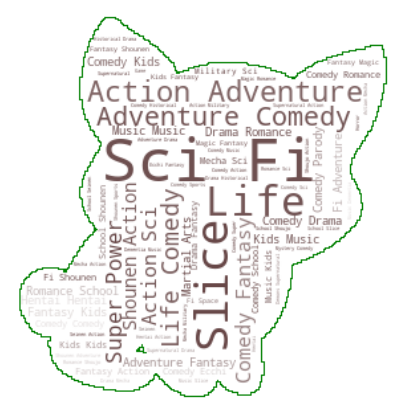

In [35]:
# Concatenar los géneros en un sólo string para grafico de wordcloud
genre_text = ' '.join(anime['Genres'].dropna())

# Definir la imagen de la máscara
mask = np.array(Image.open("anime.png"))
image_colors = ImageColorGenerator(mask)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=600, height=600, background_color='white', mask=mask, contour_width=1, contour_color='green').generate(genre_text)

# Convert the WordCloud object to an image
wordcloud_image = wordcloud.to_image()

# Create a Plotly figure to display the WordCloud image
plt.figure(figsize=(4,4), facecolor=None)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [36]:
# Gráfico de violín para popularidad por tipo
fig = px.violin(anime, x='Type', y='Popularity', 
                labels={'Type':'Tipo de animé', 'Popularity':'Popularidad'},
                title='Distribución de popularidad por tipo de animé',
                color='Type')

fig.show()

In [37]:
# Box plot de scores por tipo
fig = px.box(anime, x='Type', y='Score', 
             labels={'Type':'Tipo', 'Score':'Score'},
             title='Distribución de animé por tipo',
             color='Type')

fig.show()

### Usamos la librería plotly para los gráficos, la ventaja es que el gráfico es interactivo, la desventaja es que hay que correr la nbk para que anden. A fines ilustrativos, copiamos aqui los gráficos generados.

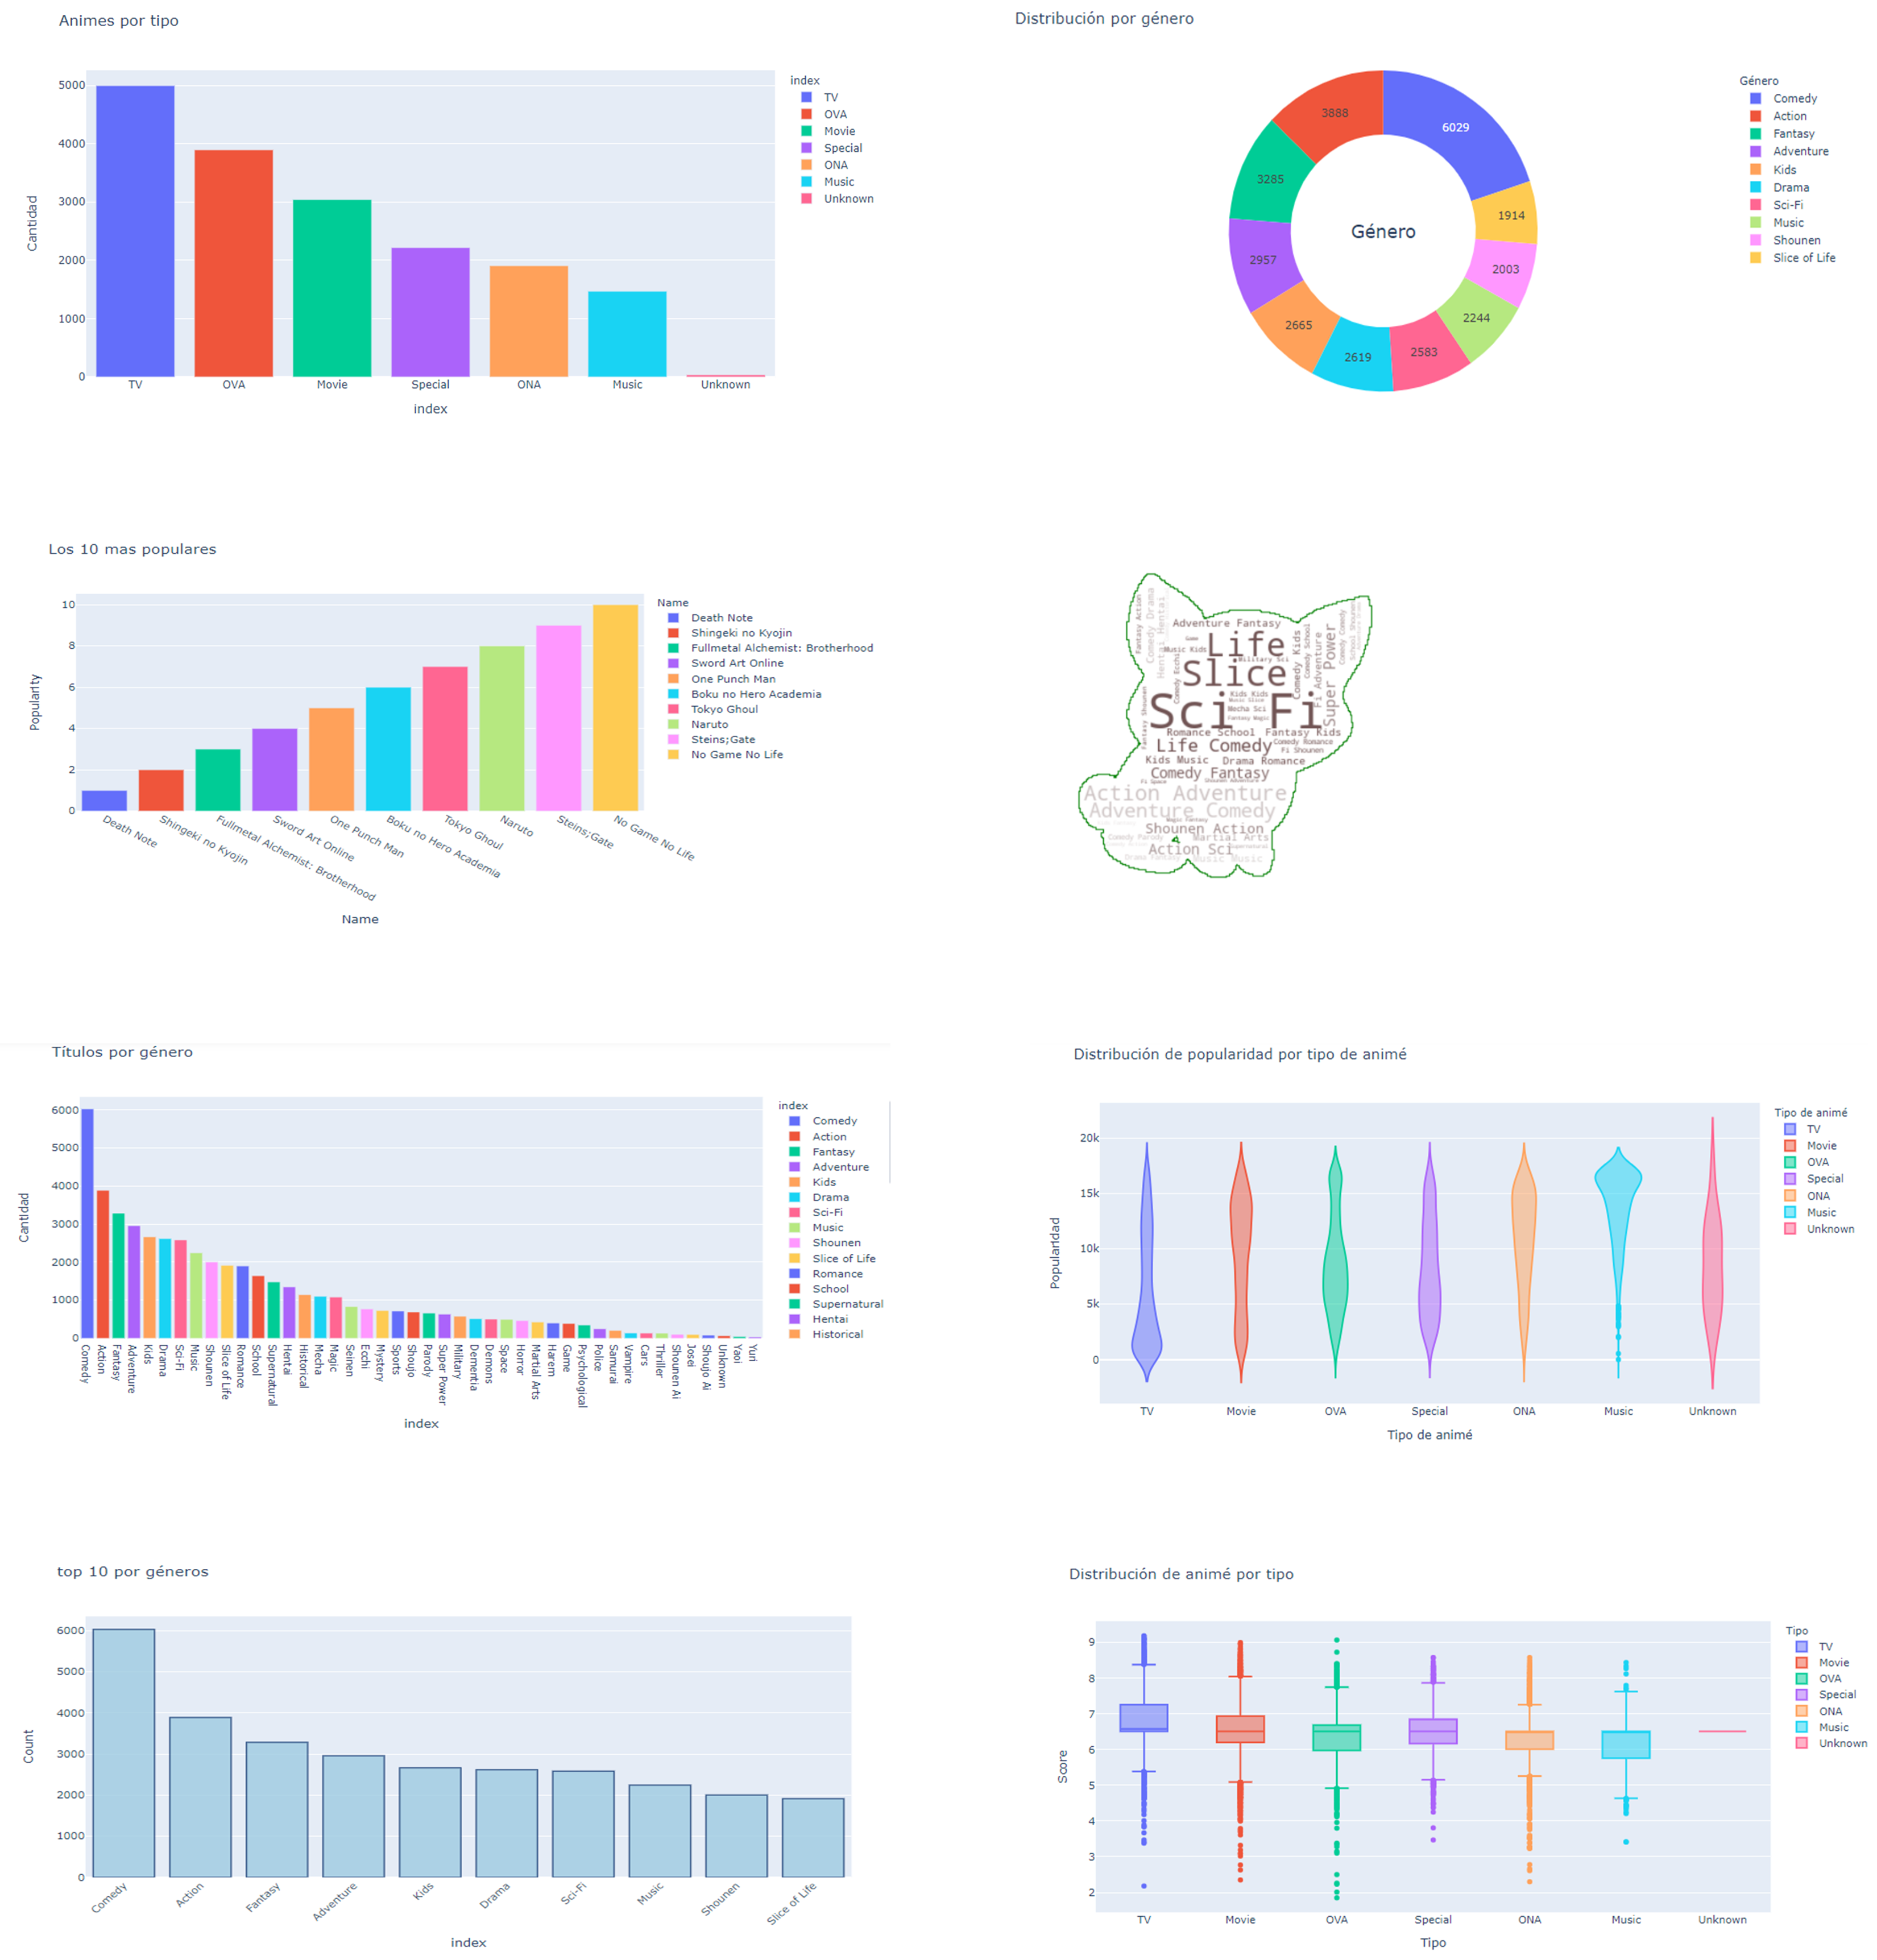

In [38]:
# Seleccionamos las columnas mas interesantes
anime_metadata = anime_metadata[['anime_id',  'Score', 'Genres', 'English name', 'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration']]

Para que podamos correr el notebook con los recursos disponibles, limitaremos la cantidad de usuarios. 
Lo propamos con 20.000 y daba un MAP muy bajo.
Vamos a seleccionar 100.000 usuarios random. Esto afectará las métricas.
Nos dio error por falta de memoria. Probaremos con 40.000
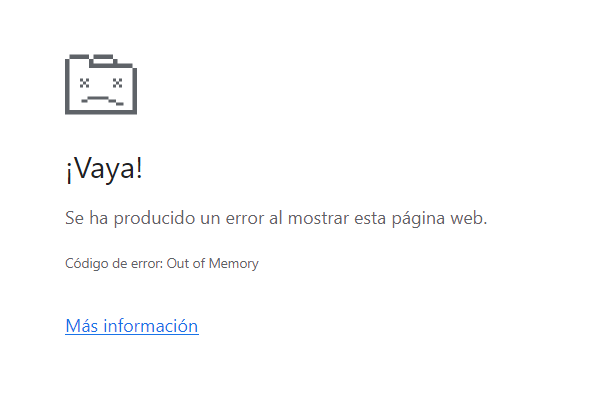

In [39]:
import random
random.seed(0)

selected_users = random.sample(list(interactions_selected['user_id'].unique()), k=40000)

interactions_selected = interactions_selected[interactions_selected['user_id'].isin(selected_users)]


In [40]:
interactions_selected

,user_id,anime_id,rating
1968,7,26349,8
1969,7,23251,9
1970,7,14753,7
1971,7,23755,0
1972,7,6682,6
...,...,...,...
109223353,353396,339,0
109223354,353396,7311,0
109223355,353396,2001,0
109223356,353396,33352,0


In [41]:
interactions_selected.rating.value_counts()

0     5711113
8     1876192
7     1731202
9     1247022
6      915307
10     861823
5      492139
4      225386
3      112129
2       68006
1       62464
Name: rating, dtype: int64

##### 1. Dividir el conjunto de datos en conjuntos de entrenamiento y prueba, utilizando una proporción adecuada.

In [42]:
%%time
# Unimos los DataFrames por la columna 'anime_id'
merged_df = interactions_selected.merge(anime_metadata, on='anime_id')

CPU times: total: 10.7 s
Wall time: 12.6 s


In [43]:
%%time
# Dividimos el DataFrame en train y test con una proporción 70-30
interactions_train, interactions_test = train_test_split(merged_df, test_size=0.3, random_state=42)


CPU times: total: 8.83 s
Wall time: 9.09 s


In [44]:
# Reindexamos los DataFrame
train = interactions_train.reset_index(drop=True)
test = interactions_test.reset_index(drop=True)

In [45]:
interactions_train.shape

(9311948, 15)

In [46]:
interactions_test.shape

(3990835, 15)

Ya estamos en condiciones de armar la matriz de interacciones

In [47]:
user_anime_interaction = pd.pivot_table(interactions_train[["user_id", "anime_id", "rating"]], index='user_id', columns='anime_id', values='rating')

# Completamos nulos con 0
user_anime_interaction = user_anime_interaction.fillna(0)

user_anime_interaction.sample(10)

anime_id,1,5,6,7,8,15,16,17,18,19,...,48426,48438,48441,48442,48456,48470,48471,48483,48488,48491
user_id,,,,,,,,,,,,,,,,,,,,,
246091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257523,9.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
351770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
user_anime_interaction.shape

(39860, 17378)

Y el diccionario para futura referencia:

In [49]:
user_id = list(user_anime_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [50]:
item_id = list(user_anime_interaction.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

Convertimos a csr matrix:

In [51]:
user_anime_interaction_csr = csr_matrix(user_anime_interaction.values)
user_anime_interaction_csr

<39860x17378 sparse matrix of type '<class 'numpy.float64'>'
	with 5314766 stored elements in Compressed Sparse Row format>

##### 2. Desarrollar un sistema de recomendación capaz de generar 20 recomendaciones por usuario.

In [57]:
from lightfm import LightFM

In [58]:
model = LightFM(learning_rate=0.03,
                no_components=20)

In [60]:
#leemos el modelo para evitar volver a correrlo 
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

In [55]:
#%%time
# correrlo solo la primera vez
#model = model.fit(user_anime_interaction_csr,
#                  epochs=100, verbose=True)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [30:28<00:00, 18.28s/it]

CPU times: total: 30min 16s
Wall time: 30min 28s


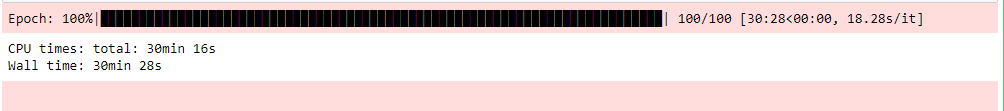

In [56]:
# Grabamos el modelo con Pickle
#with open('model.pkl', 'wb') as file:
#    pickle.dump(model, file)

Y ahora definimos la funcion para obtener recomendaciones para un usuario en específico:

In [61]:
def recomm(model, interactions, user_id, user_dict, item_dict, nrec_items = 20, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]

    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                [interactions.loc[user_id,:] > 0].index).sort_values(ascending=False))
    
    #Filtro de items que ya leyó el usuario
    scores = [x for x in scores if x not in known_items]
    recomms = scores[0:nrec_items]

    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + str(i))
            counter+=1

        print("\n Recommended Items:")
        
        counter = 1
        for i in recomms:
            print(str(counter) + '- ' + str(i))
            counter+=1
    return recomms

Probamos la función para un usuario al azar. Al poner la opción show=True nos imprime los known likes y recomms.



In [62]:
recomms_test = recomm(model, user_anime_interaction, 337984, user_dict, item_dict, show=True)

User: 337984
Known Likes:
1- 10165
2- 10033
3- 9919
4- 8479
5- 7674
6- 7017
7- 6046
8- 6045
9- 5998
10- 5774
11- 4898
12- 4814
13- 4104
14- 3656
15- 3457
16- 3375
17- 3359
18- 3210
19- 3092
20- 2890
21- 2313
22- 2290
23- 2159
24- 2154
25- 1829
26- 1678
27- 1604
28- 1575
29- 1535
30- 1430
31- 1217
32- 1118
33- 1087
34- 1033
35- 977
36- 915
37- 877
38- 853
39- 850
40- 813
41- 746
42- 743
43- 741
44- 738
45- 733
46- 724
47- 578
48- 572
49- 523
50- 513
51- 512
52- 507
53- 408
54- 405
55- 317
56- 269
57- 199
58- 149
59- 121
60- 93
61- 24
62- 21
63- 20

 Recommended Items:
1- 16498
2- 11757
3- 5114
4- 30276
5- 6547
6- 22319
7- 4224
8- 9253
9- 19815
10- 10620
11- 1735
12- 32281
13- 2904
14- 226
15- 31964
16- 11111
17- 21881
18- 6702
19- 2167
20- 20507


In [63]:
recomms_test

[16498,
 11757,
 5114,
 30276,
 6547,
 22319,
 4224,
 9253,
 19815,
 10620,
 1735,
 32281,
 2904,
 226,
 31964,
 11111,
 21881,
 6702,
 2167,
 20507]

Si queremos ver el nombre de estos animes, podemos buscar en el dataset de metadata

In [64]:
anime_metadata.loc[anime_metadata.anime_id.isin(recomms_test), "English name"].values

array(['Elfen Lied', 'Naruto:Shippuden', 'Clannad',
       'Code Geass:Lelouch of the Rebellion R2', 'Toradora!',
       'Fullmetal Alchemist:Brotherhood', 'Angel Beats!', 'Fairy Tail',
       'Steins;Gate', 'The Future Diary', 'Another', 'Sword Art Online',
       'Attack on Titan', 'No Game, No Life', 'Noragami:Stray God',
       'Sword Art Online II', 'Tokyo Ghoul', 'One Punch Man',
       'My Hero Academia', 'Your Name.'], dtype=object)

##### 3. Las recomendaciones deben estar en términos de ”anime id” (identificador del anime) y deben ser para aquellos que el usuario aún no haya visto según los datos del conjunto de entrenamiento.

In [65]:
# Nos fijamos cuales de las recomendadas, el usuario 337984 ya vio.

In [66]:
train[(train.user_id==337984) & (train.anime_id.isin(recomms_test))].anime_id.unique()

array([2904], dtype=int64)

In [67]:
# en este caso ya habia visto la 2904. Como podemos asegurarnos que esto no pase?

In [68]:
user_watched = train[train.user_id == 337984].anime_id.unique()
user_watched

array([ 2154,  5681,  2159,    64,  8449,   733,   746,  7337,   813,
         269,   523,  8634,  4898,   405,  5998,    24,  1829,  2313,
        3375,  1430,    22,  5774,  4814,  3457,  1033,  1689,  8063,
        8423,  2890,   199,   915,   977,  1118,  1604,   738,  1535,
         853, 10033,    20,   877,  3656,  7017,   578,  5040,  2290,
        6046,  9919,   121,   507,  8479,  4104,  3572,   741,   572,
         850,  7058,    21,  3092,  7193,   322,  2904,  3210,   724,
        1575,  9893,  1678, 10165,  1087,   325,   408,   743,    93,
        1217,  1869,   317,   849,  6418,   513,   512,  7674,  5530,
        6045,  3359,   149], dtype=int64)

In [69]:
# filtramos las peliculas que ya vio del resultado
recomms_337984 = [rec for rec in recomms_test if rec not in user_watched]
recomms_337984

[16498,
 11757,
 5114,
 30276,
 6547,
 22319,
 4224,
 9253,
 19815,
 10620,
 1735,
 32281,
 226,
 31964,
 11111,
 21881,
 6702,
 2167,
 20507]

In [70]:
#Como solo nos muestra 19, redefinimos la funcion para que en lugar de 20 nos recomiende 100:
def recomm100(model, interactions, user_id, user_dict, item_dict, nrec_items = 100, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]

    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                [interactions.loc[user_id,:] > 0].index).sort_values(ascending=False))
    
    #Filtro de items que ya leyó el usuario
    scores = [x for x in scores if x not in known_items]
    recomms = scores[0:nrec_items]

    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + str(i))
            counter+=1

        print("\n Recommended Items:")
        
        counter = 1
        for i in recomms:
            print(str(counter) + '- ' + str(i))
            counter+=1
    return recomms

In [71]:
recomms_test100 = recomm100(model, user_anime_interaction, 337984, user_dict, item_dict, show=True)

User: 337984
Known Likes:
1- 10165
2- 10033
3- 9919
4- 8479
5- 7674
6- 7017
7- 6046
8- 6045
9- 5998
10- 5774
11- 4898
12- 4814
13- 4104
14- 3656
15- 3457
16- 3375
17- 3359
18- 3210
19- 3092
20- 2890
21- 2313
22- 2290
23- 2159
24- 2154
25- 1829
26- 1678
27- 1604
28- 1575
29- 1535
30- 1430
31- 1217
32- 1118
33- 1087
34- 1033
35- 977
36- 915
37- 877
38- 853
39- 850
40- 813
41- 746
42- 743
43- 741
44- 738
45- 733
46- 724
47- 578
48- 572
49- 523
50- 513
51- 512
52- 507
53- 408
54- 405
55- 317
56- 269
57- 199
58- 149
59- 121
60- 93
61- 24
62- 21
63- 20

 Recommended Items:
1- 16498
2- 11757
3- 5114
4- 30276
5- 6547
6- 22319
7- 4224
8- 9253
9- 19815
10- 10620
11- 1735
12- 32281
13- 2904
14- 226
15- 31964
16- 11111
17- 21881
18- 6702
19- 2167
20- 20507
21- 8074
22- 11061
23- 31043
24- 23273
25- 28851
26- 31240
27- 9989
28- 33486
29- 25777
30- 22199
31- 27899
32- 3588
33- 2001
34- 30
35- 4181
36- 22535
37- 23755
38- 431
39- 30831
40- 6746
41- 9756
42- 11617
43- 5081
44- 1
45- 15809
46- 18679
47

In [72]:
#filtramos las peliculas que ya vio del resultado
recomms_337984 = [rec for rec in recomms_test100 if rec not in user_watched]
recomms_337984 [0:19]

[16498,
 11757,
 5114,
 30276,
 6547,
 22319,
 4224,
 9253,
 19815,
 10620,
 1735,
 32281,
 226,
 31964,
 11111,
 21881,
 6702,
 2167,
 20507]

##### 4. Evaluar el sistema de recomendación utilizando una métrica adecuada.

In [73]:
# haremos tratamiento de los usuarios que no tengan recomendaciones, a esos les recomendaremos las que tengan un raiting medio.
cold_start_recomms = interactions_train.groupby("anime_id").agg({"rating": "mean"})\
                      .sort_values(by="rating", ascending=False)\
                      .head(20)\
                      .index\
                      .to_list()

A todos los usuarios cold start les recomendaremos:

In [74]:
cold_start_recomms

[42061,
 39207,
 1535,
 38524,
 2904,
 199,
 37135,
 35279,
 35272,
 40794,
 45053,
 40378,
 32281,
 16498,
 30276,
 41495,
 32935,
 28891,
 431,
 5114]

Ahora generemos recomendaciones para todos los usuarios.

Primero comenzamos armando un listado de usuarios "non cold" a los cuales les daremos recomms personalizadas.

In [75]:
users = interactions_selected.user_id.unique()
non_cold_users = interactions_train.user_id.unique()

print(len(users), len(non_cold_users))

40000 39860


In [76]:
%%time
recomms_dict = {
    "user": [],
    "recomms": [],
    "cold": []
}

for user in users:
  
  # Recomms personalizadas
  if user in non_cold_users:
    user_recomms = recomm(model, user_anime_interaction, user, user_dict, item_dict, nrec_items = 20, show = False)
    recomms_dict["user"].append(user)
    recomms_dict["recomms"].append(user_recomms)
    recomms_dict["cold"].append(False) #Para luego tener identificados a los usuarios cold
  
  # Recomms cold
  else:
    recomms_dict["user"].append(user)
    recomms_dict["recomms"].append(cold_start_recomms)
    recomms_dict["cold"].append(True) #Para luego tener identificados a los usuarios cold

CPU times: total: 23min 34s
Wall time: 24min 12s


Ahora tenemos un diccionario de recomedaciones. Lo vamos a convertir en dataframe para poder manipularlo más fácil (como estamos acostumbrados)

In [77]:
recomms_df = pd.DataFrame(recomms_dict)

In [78]:
# como tarda mucho en generar el diccionario, para no volver a correrlo lo vamos a guardar como dataset
recomms_df.to_csv("recomms.csv", index=False)
# si lo queremos leer:
#recomms_df = pd.read_csv("recomms.csv") 

In [79]:
recomms_df.head()

,user,recomms,cold
0,7,"[1535, 16498, 11757, 20, 30276, 1575, 9253, 32...",False
1,12,"[1535, 16498, 11757, 20, 5114, 30276, 22319, 4...",False
2,34,"[16498, 20, 5114, 30276, 1575, 6547, 22319, 42...",False
3,36,"[16498, 11757, 20, 5114, 30276, 1575, 22319, 1...",False
4,57,"[16498, 11757, 30276, 6547, 22319, 4224, 9253,...",False


In [80]:
recomms_df.user.nunique()

40000

In [81]:
recomms_df.cold.value_counts()

False    39860
True       140
Name: cold, dtype: int64

Ahora tenemos que comparar nuestras recomms contra lo que los usuarios realmente vieron (test).



In [82]:
interactions_test.head()

,user_id,anime_id,rating,Score,Genres,English name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration
7464852,176559,985,9,7.72,"Adventure, Drama, Fantasy, Shounen",Dragon Ball Z Special 2:The History of Trunks,Special,1,"Feb 24, 1993",Unknown,Unknown,Funimation,Toei Animation,Manga,48 min.
9812294,221016,31456,4,6.65,"Military, Harem, Historical, Romance, Fantasy,...",Code:Realize ~Guardian of Rebirth~,TV,12,"Oct 7, 2017 to Dec 23, 2017",Fall 2017,"Frontier Works, Lantis, AT-X, DAX Production, ...",Funimation,M.S.C,Visual novel,23 min. per ep.
8339941,185369,1550,4,6.76,"Drama, Shoujo, Sports",Unknown,TV,104,"Dec 7, 1969 to Nov 28, 1971",Winter 1970,Fuji TV,Unknown,Tokyo Movie Shinsha,Manga,24 min. per ep.
6269402,60976,35788,7,8.14,"Ecchi, School, Shounen",Food Wars! The Third Plate,TV,12,"Oct 4, 2017 to Dec 20, 2017",Fall 2017,"Lantis, Warner Bros. Japan, KlockWorx, Shueisha",Sentai Filmworks,J.C.Staff,Manga,24 min. per ep.
6967910,93296,34933,7,7.42,"Game, Mystery, Psychological, Drama, School, S...",Kakegurui:Compulsive Gambler,TV,12,"Jul 1, 2017 to Sep 23, 2017",Summer 2017,"Dentsu, Square Enix, Mainichi Broadcasting Sys...",Unknown,MAPPA,Manga,24 min. per ep.


Primero ordenamos los animes según los ratings (mayor a menor) que dieron los usuarios en el set de test.

Luego, agrupamos y armamos un listado de animes para cada usuario.

Este es el listado "ideal" contra el que vamos a comparar nuestras recomendaciones.

In [83]:
ideal_recomms = interactions_test.sort_values(by=["user_id", "rating"], ascending=False)\
                  .groupby(["user_id"], as_index=False)\
                  .agg({"anime_id": "unique"})\
                  .head()
ideal_recomms.head()

,user_id,anime_id
0,7,"[23251, 5680, 11981, 431, 10521, 6007, 12355, ..."
1,12,"[16498, 48, 1735, 11759, 20, 5681, 356, 565, 1..."
2,34,"[5341, 9926, 7054, 5680, 861, 8476, 392, 11123..."
3,36,"[317, 11741, 4107, 11981, 1575, 6675, 1689, 29..."
4,57,"[66, 186, 2904, 264, 5681, 8074, 24, 846, 227,..."


Ahora vamos a medir MAP. Para esto nos basaremos en este ejemplo: https://github.com/Datathon2021/Recomendador/blob/main/Ejemplos/ejemplo_map.ipynb

Sklearn también tiene funciones para medir NDCG, etc.


Primero que nada, vamos a unir en un mismo dataframe las recomendaciones nuestras con el set ideal.

In [84]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="user_id", right_on="user")[["user_id", "anime_id", "recomms"]]
df_map.columns = ["user_id", "ideal", "recomms"]
df_map.head()

,user_id,ideal,recomms
0,7,"[23251, 5680, 11981, 431, 10521, 6007, 12355, ...","[1535, 16498, 11757, 20, 30276, 1575, 9253, 32..."
1,12,"[16498, 48, 1735, 11759, 20, 5681, 356, 565, 1...","[1535, 16498, 11757, 20, 5114, 30276, 22319, 4..."
2,34,"[5341, 9926, 7054, 5680, 861, 8476, 392, 11123...","[16498, 20, 5114, 30276, 1575, 6547, 22319, 42..."
3,36,"[317, 11741, 4107, 11981, 1575, 6675, 1689, 29...","[16498, 11757, 20, 5114, 30276, 1575, 22319, 1..."
4,57,"[66, 186, 2904, 264, 5681, 8074, 24, 846, 227,...","[16498, 11757, 30276, 6547, 22319, 4224, 9253,..."


In [85]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)


### MAP para 20.000 usuarios y 10 epocas.
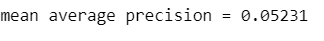

El mean average precision (MAP) es una medida comúnmente utilizada en la evaluación de sistemas de recomendación. En términos simples, el MAP mide la calidad general de las recomendaciones de un modelo, teniendo en cuenta tanto la precisión como la exhaustividad.

En este caso, si el valor de MAP dio 0.05231, significa que el modelo tiene una calidad de recomendación relativamente baja. Un valor de MAP cercano a 1.0 indicaría una calidad de recomendación muy alta, mientras que un valor cercano a 0.0 indicaría una calidad muy baja.

Es importante tener en cuenta que el MAP puede ser influenciado por varios factores, incluyendo el tamaño del conjunto de datos y la complejidad del modelo. Por lo tanto, es importante considerar el contexto específico al interpretar el valor del MAP.

Los parámetros elegidos fueron 20.000 usuarios y 10 epocs.

Por lo que tambien podría deberse a los recortes realizados por las limitaciónes de HW para correr el modelo.

probamos para 100 epocas pero dió peor:

### MAP para 20.000 usuarios y 100 epocas.


Con 100.000 usuarios, nos dio error de memoria.
Por lo que finalmente optamos por 40.000 usuarios y 10 epocas. Vemos que se logrú una pequeña mejora.

In [86]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.06255


Este resultado tambien tiene sentido porque el modelo obtiene que animes podrían gustarle al usuario, lo cual como se trata de peliculas que no vio, en el set de testeo no están las respuestas correctas para comparar.

### Concluisión final:

En el contexto del modelo de recomendación de animes a usuarios, un valor de MAP de 0.06255 indica una calidad de recomendación relativamente baja. Esto significa que el modelo tiene dificultades para hacer recomendaciones precisas y exhaustivas a los usuarios. Un valor de MAP cercano a 1.0 indicaría una calidad de recomendación muy alta, mientras que un valor cercano a 0.0 indicaría una calidad de recomendación muy baja.

En este caso, el valor del MAP puede estar influenciado por varios factores, como el tamaño del conjunto de datos (limitado por el HW utilizado) y la complejidad del modelo.